In [111]:
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import torch

sys.path.insert(0, "./../")

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [112]:
from src.datasets.threedpw import ThreeDPW
from src.datasets.datasets_common import UNNORMALIZE

from src.models.raft import get_raft_pretrained
from src.utils.optical_flow_vis_utils import flow_to_image, get_max_flow, scale_log, scale_rt

In [113]:
device = "cuda:0"
model = get_raft_pretrained()

model.to(device)
model.eval();

# tests on 3DPW images

In [114]:
dset = ThreeDPW(set="train", seqlen=100, debug=True)
print(len(dset))
x = dset[0]
print(x.keys(), x["video"].shape)

3DPW Dataset overlap ratio:  0.0
Loaded 3dpw dataset from /cvlabdata2/home/davydov/videoHMR_SSL/data/3dpw/3dpw_processed/train/3dpw_train_db.pt
3dpw - number of dataset objects 210
210
dict_keys(['features', 'theta', 'kp_2d', 'kp_3d', 'w_smpl', 'w_3d', 'instance_id', 'bbox', 'video']) torch.Size([100, 3, 224, 224])


In [115]:
def visualize_optical_flow(img1, img2, flow):
    img1 = img1[0].permute(1, 2, 0).cpu().numpy()
    img2 = img2[0].permute(1, 2, 0).cpu().numpy()
    flow = flow[0].permute(1, 2, 0).cpu().numpy()

    # map flow to rgb image
    flow = flow_to_image(flow)
    img_flo = np.concatenate([img1, img2, flow], axis=1)

    fig, ax = plt.subplots(1,1,figsize=(15,5))
    ax.imshow(img_flo / 255.0)
    ax.grid(False)
    ax.set_axis_off()
    return fig, ax

In [139]:
# x, start_index, end_index = dset[0], 47, 50
# x, start_index, end_index = dset[100], 0, 1
x, start_index, end_index = dset[150], 5, 7

video = x['video']
video = UNNORMALIZE(video).to(device)
image1 = video[start_index:start_index+1]
image2 = video[end_index:end_index+1]

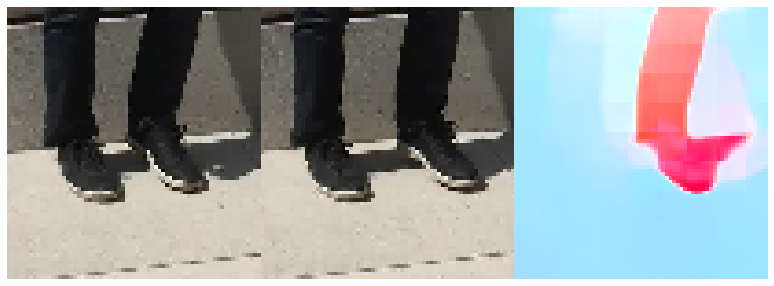

In [140]:
with torch.no_grad():
    flow_low, flow_up = model(image1, image2, iters=20, test_mode=True)

l, r, t, b = 81, 150, 150, 224
_ = visualize_optical_flow(image1[:, :, t:b, l:r], image2[:, :, t:b, l:r], flow_up[:, :, t:b, l:r])

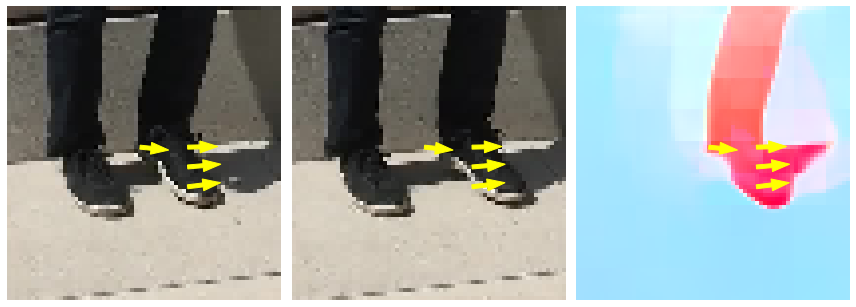

In [144]:
img1 = image1.detach().cpu()[0].permute(1, 2, 0)
img2 = image2.detach().cpu()[0].permute(1, 2, 0)
flow = flow_up.detach().cpu()[0].permute(1, 2, 0)
flow_vis = flow_to_image(flow.numpy())
u = flow[..., 0]
v = flow[..., 1]

### mask to find better region
l, r, t, b = 81, 150, 150, 224
img1_ = img1[t:b, l:r]
img2_ = img2[t:b, l:r]
u = u[t:b, l:r]
v = v[t:b, l:r]
flow_vis = flow_vis[t:b, l:r]

ps = [(33, 35), (45, 35), (45, 45), (45, 40)]  # x,y

fig, ax = plt.subplots(1, 3, figsize=(12, 5))
for axis, img in zip(ax, [img1_, img2_, flow_vis]):
    axis.imshow(img)
    axis.set_axis_off()
    for px, py in ps:
        axis.arrow(px, py, u[py, px], v[py, px], width=1, color="yellow")
fig.tight_layout()

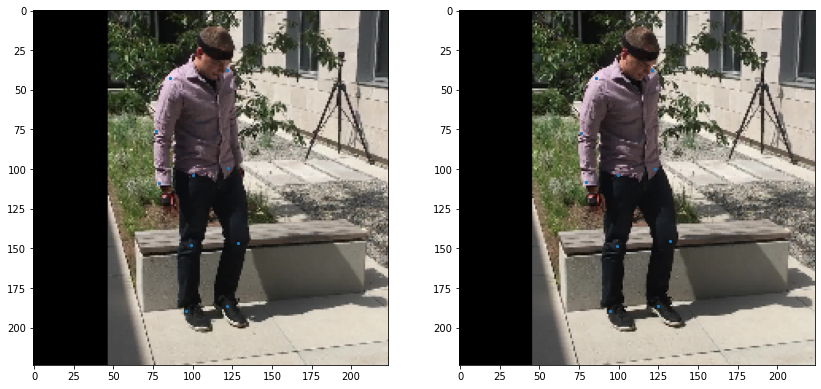

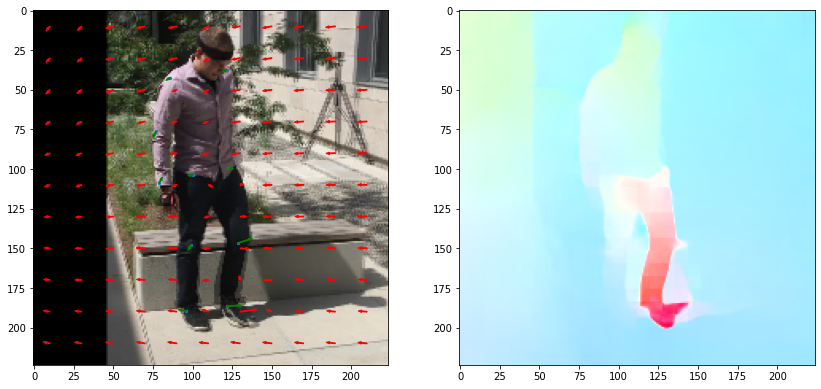

In [145]:
kp_2d_1 = x['kp_2d'][idx1].clone()
kp_2d_1[:,:2] = (kp_2d_1[:,:2] + 1) / 2 * 224

kp_2d_2 = x['kp_2d'][idx2].clone()
kp_2d_2[:,:2] = (kp_2d_2[:,:2] + 1) / 2 * 224

mask_vis = (kp_2d_1[:,2] > 0.) * (kp_2d_2[:,2] > 0.)

kp_2d_1 = kp_2d_1[mask_vis]
kp_2d_2 = kp_2d_2[mask_vis]

fig, ax = plt.subplots(1,2,figsize=(14,7))
ax[0].imshow(img1)
ax[1].imshow(img2)

ax[0].scatter(kp_2d_1[:,0], kp_2d_1[:,1], s=5)
ax[1].scatter(kp_2d_2[:,0], kp_2d_2[:,1], s=5)

fig, ax = plt.subplots(1,2,figsize=(14,7))
ax[0].imshow(img1/255 / 2 + img2/255 / 2)
    
ax[0].scatter(kp_2d_1[:,0], kp_2d_1[:,1], s=5)
for x_, y_, dx_, dy_ in zip(kp_2d_1[:,0], kp_2d_1[:,1], kp_2d_2[:,0] - kp_2d_1[:,0], kp_2d_2[:,1] - kp_2d_1[:,1]):
    ax[0].arrow(x_, y_, dx_*2, dy_*2, width=0.5, color='green')

for x_ in range(10, 220, 20):
    for y_ in range(10, 220, 20):    
        u_, v_ = flow_up[0, :, int(y_), int(x_)].cpu()
        ax[0].arrow(x_, y_, u_*2, v_*2, width=0.5, color='red')
    
# print(flows.shape)
flow_orig = flow_to_image(flow_up.permute(0,2,3,1)[0].cpu().numpy())
ax[1].imshow(flow_orig)

# write OF video

In [11]:
dset = ThreeDPW(set="train", seqlen=300, debug=True)
print(len(dset))
x = dset[0]
print(x.keys())
x["video"].shape

3DPW Dataset overlap ratio:  0.0
Loaded 3dpw dataset from /cvlabdata2/home/davydov/videoHMR_SSL/data/3dpw/3dpw_processed/train/3dpw_train_db.pt
3dpw - number of dataset objects 62
62
dict_keys(['features', 'theta', 'kp_2d', 'kp_3d', 'w_smpl', 'w_3d', 'video'])


torch.Size([300, 3, 224, 224])

In [12]:
from tqdm import tqdm

torch.set_grad_enabled(False)
frames = UNNORMALIZE(dset[0]["video"]).to(device)  # 300 x 3 x 224 x 224
img1 = frames[0].unsqueeze(0)
img2 = frames[1].unsqueeze(0)
_, flows = model(img1, img2, iters=20, test_mode=True)
img1 = img2.clone()
for i in tqdm(range(2, len(frames))):
    img2 = frames[i].unsqueeze(0)  # next frame
    _, flow = model(img1, img2, iters=20, test_mode=True)
    flows = torch.cat((flows, flow), dim=0)
    img1 = img2.clone()  # update previous frame

frames.shape, flows.shape

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 298/298 [00:26<00:00, 11.40it/s]


(torch.Size([300, 3, 224, 224]), torch.Size([299, 2, 224, 224]))

In [13]:
img1_flows = []
l, r, t, b = 62, 162, 0, 224
for img1, flow in zip(frames, flows):
    img1 = img1.cpu().permute(1, 2, 0).numpy()[t:b, l:r]
    flow = flow.cpu().permute(1, 2, 0).numpy()
    flow = flow_to_image(flow)[t:b, l:r]
    img1_flow = np.concatenate((img1, flow), axis=1)
    img1_flows.append(img1_flow)

img1_flows = np.array(img1_flows).astype(np.uint8)

In [14]:
from src.utils.video_utils import write_video
import numpy as np
import os

save_dir = "./../dump_from_raft/optical_flow"
os.makedirs(save_dir, exist_ok=True)

299it [00:03, 76.16it/s]


Video is saved to './../dump_from_raft/optical_flow/img__OForig__OForig_norm__OFrt0.6_norm__OFlog_norm.mp4'


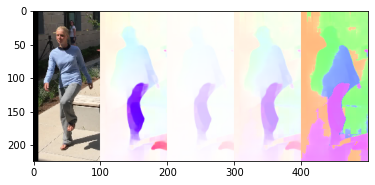

In [15]:
from src.utils.optical_flow_vis_utils import flow_to_image

rt_power = 0.6

l, r, t, b = 62, 162, 0, 224  # for visual box

global_max = get_max_flow(flows.cpu().permute(0, 2, 3, 1).numpy())
global_max_rt = get_max_flow(scale_rt(flows.cpu().permute(0, 2, 3, 1).numpy(), power=rt_power))
global_max_log = get_max_flow(scale_log(flows.cpu().permute(0, 2, 3, 1).numpy()))

img1_flows = []
for img1, flow in tqdm(zip(frames, flows)):
    img1 = img1.cpu().permute(1, 2, 0).numpy()[t:b, l:r]
    flow = flow.cpu().permute(1, 2, 0).numpy()[t:b, l:r]
    flow_orig = flow_to_image(flow)
    flow_orig_global_norm = flow_to_image(flow, max_val=global_max)
    flow_rt_global_norm = flow_to_image(scale_rt(flow, power=rt_power), max_val=global_max_rt)
    flow_log_global_norm = flow_to_image(scale_log(flow), max_val=global_max_log)  # too harsh mapping

    img1_flow = np.concatenate(
        (img1, flow_orig, flow_orig_global_norm, flow_rt_global_norm, flow_log_global_norm), axis=1
    )
    img1_flows.append(img1_flow)

img1_flows = np.array(img1_flows).astype(np.uint8)
write_video(img1_flows, f"{save_dir}/img__OForig__OForig_norm__OFrt{rt_power}_norm__OFlog_norm.mp4", fps=20)

plt.imshow(img1_flows[100])

# Test on Sintel demo frames

In [16]:
# from glob import glob
# device = "cuda:0"

# sintel_path = "/data/sandcastle/boxes/fbsource/fbcode/ar_sharing/body_tracking_3d/models/raft/demo-frames"
# img_paths = sorted(glob(f"{sintel_path}/*.png"))
# imgs = [torch.tensor(plt.imread(img_path)) for img_path in img_paths]
# imgs = torch.stack(imgs).to(device).permute(0, 3, 1, 2)[...,2:-2,296:-296]
# print(imgs.shape)
# imgs = torch.nn.functional.pad(imgs, (0, 0, 147, 147))
# print(imgs.shape)


# with torch.no_grad():
#     _, flows = model(imgs[:-1], imgs[1:], iters=20, test_mode=True)
# print(flows.shape)


# img1_flows = []
# for img1, flow in zip(imgs[:-1], flows):
#     img1 = img1.cpu().permute(1, 2, 0).numpy()
#     img1 = (img1*255).astype(np.uint8).astype(np.uint8)
#     flow = flow.cpu().permute(1, 2, 0).numpy()

#     mag = (flow ** 2).sum(axis=2)[..., None]
#     mag = mag / mag.max() * 255
#     mag = np.tile(mag, (1, 1, 3))
#     flow = flow_to_image(flow)
#     img1_flow = np.concatenate((img1, mag, flow), axis=1)
#     img1_flows.append(img1_flow)

# img1_flows = np.array(img1_flows).astype(np.uint8)
# print(img1_flows.shape)


# from src.utils.video_utils import write_video
# savepath = "/tmp/optical_flow_sintel.mp4"
# write_video(img1_flows, savepath, fps=20)